# Simulation Analysis
In this interactive Notebook the convergence speed of the simulation algorithm is assessed. Its execution time is compared to the deterministic algorithms within the relevant range.

In [10]:
# Import the libraries used in the notebook
import pandas as pd
from matplotlib import pyplot as plt
import random
import numpy as np
from tqdm import tqdm
import scipy
import time

In [11]:
# Set the plot resolution
plt.rcParams['figure.dpi'] = 600

In [12]:
# The seed for the probabilistic functions
SEED = sum([ord(c) for c in "Social Networks Lab"])

In [13]:
# Read the dataframe with the Possession xG values
xg_df = pd.read_pickle('possession_xGs.pkl')

In [14]:
# Exact distribution
N = 11
bin_coeff = [1, 11, 55, 165, 330, 462, 462, 330, 165, 55, 11, 1]
p_is = [(1/8)] * N
reference_dist = [b*(7/8)**(N-i)*(1/8)**(i) for i, b in enumerate(bin_coeff)]

In [15]:
# The simulation algorithm
def simulation(p_is, n):
    amnts = [0]*(len(p_is)+1)
    for i in range(n):
        goal_amnt = 0
        for j, p_i in enumerate(p_is):
            # random.seed(SEED+(i+1)*(j+1))
            u = random.random()
            if u < p_i:
                goal_amnt +=1
        amnts[goal_amnt] += 1
    return [amnt/n for amnt in amnts]

# The DP algorithm
def dp(p_is):
    n = len(p_is)
    p_k = [1] + [0]*n
    # Iterate over the dp table
    for i in range(n+1):
        for c in range(i, 0, -1):
            inc = p_is[i-1]*p_k[c-1]
            p_k[c-1] -= inc
            p_k[c] += inc
    return p_k

# The FFT algorithm
from poibin.poibin import PoiBin

def fft(p_is):
    return PoiBin(p_is).get_pmf_xi()

### Comparison with the deterministic Algorithms
To get a sense on how many match simulations fit into the average execution time of the deterministic algorithms, we will compare the simulation based approach with the determinisitic approaches on in the range of execution time of the deterministic algorithms.

In [16]:
# The amount of times to repeat the experiment to get a representative result
REPEAT = 5000
average_det_exec_times = []
for _ in range(N):
    # Measuring both the execution time of the dp algorithm and the FFT algorithm, then take the average execution time of the two
    start = time.perf_counter_ns()
    dp(p_is)
    fft(p_is)
    stop = time.perf_counter_ns()
    average_det_exec_times.append((stop-start)/2)
exec_time_det_algs_microseconds = np.median(average_det_exec_times)/10e3
print(f'Median average execution time for the deterministic algorithms is {exec_time_det_algs_microseconds}µs')

Median average execution time for the deterministic algorithms is 5.8308µs


In [17]:
# Run from 1 to 500 match simulations, repeat each simulation and take the median execution time
REPEAT = 1000
SIM_MAX = 500
median_sim_exec_times = []
match_simulations = []
for s in tqdm(range(1, SIM_MAX+1)):
    match_simulations.append(s)
    exec_time_agg = []
    for _ in range(REPEAT):
        start = time.perf_counter_ns()
        simulation(p_is, s)
        stop = time.perf_counter_ns()
        exec_time_agg.append(stop-start)
    median_sim_exec_times.append(np.median(exec_time_agg)/10e3)

  7%|▋         | 33/500 [00:00<00:09, 47.08it/s] 

100%|██████████| 500/500 [02:07<00:00,  3.92it/s]


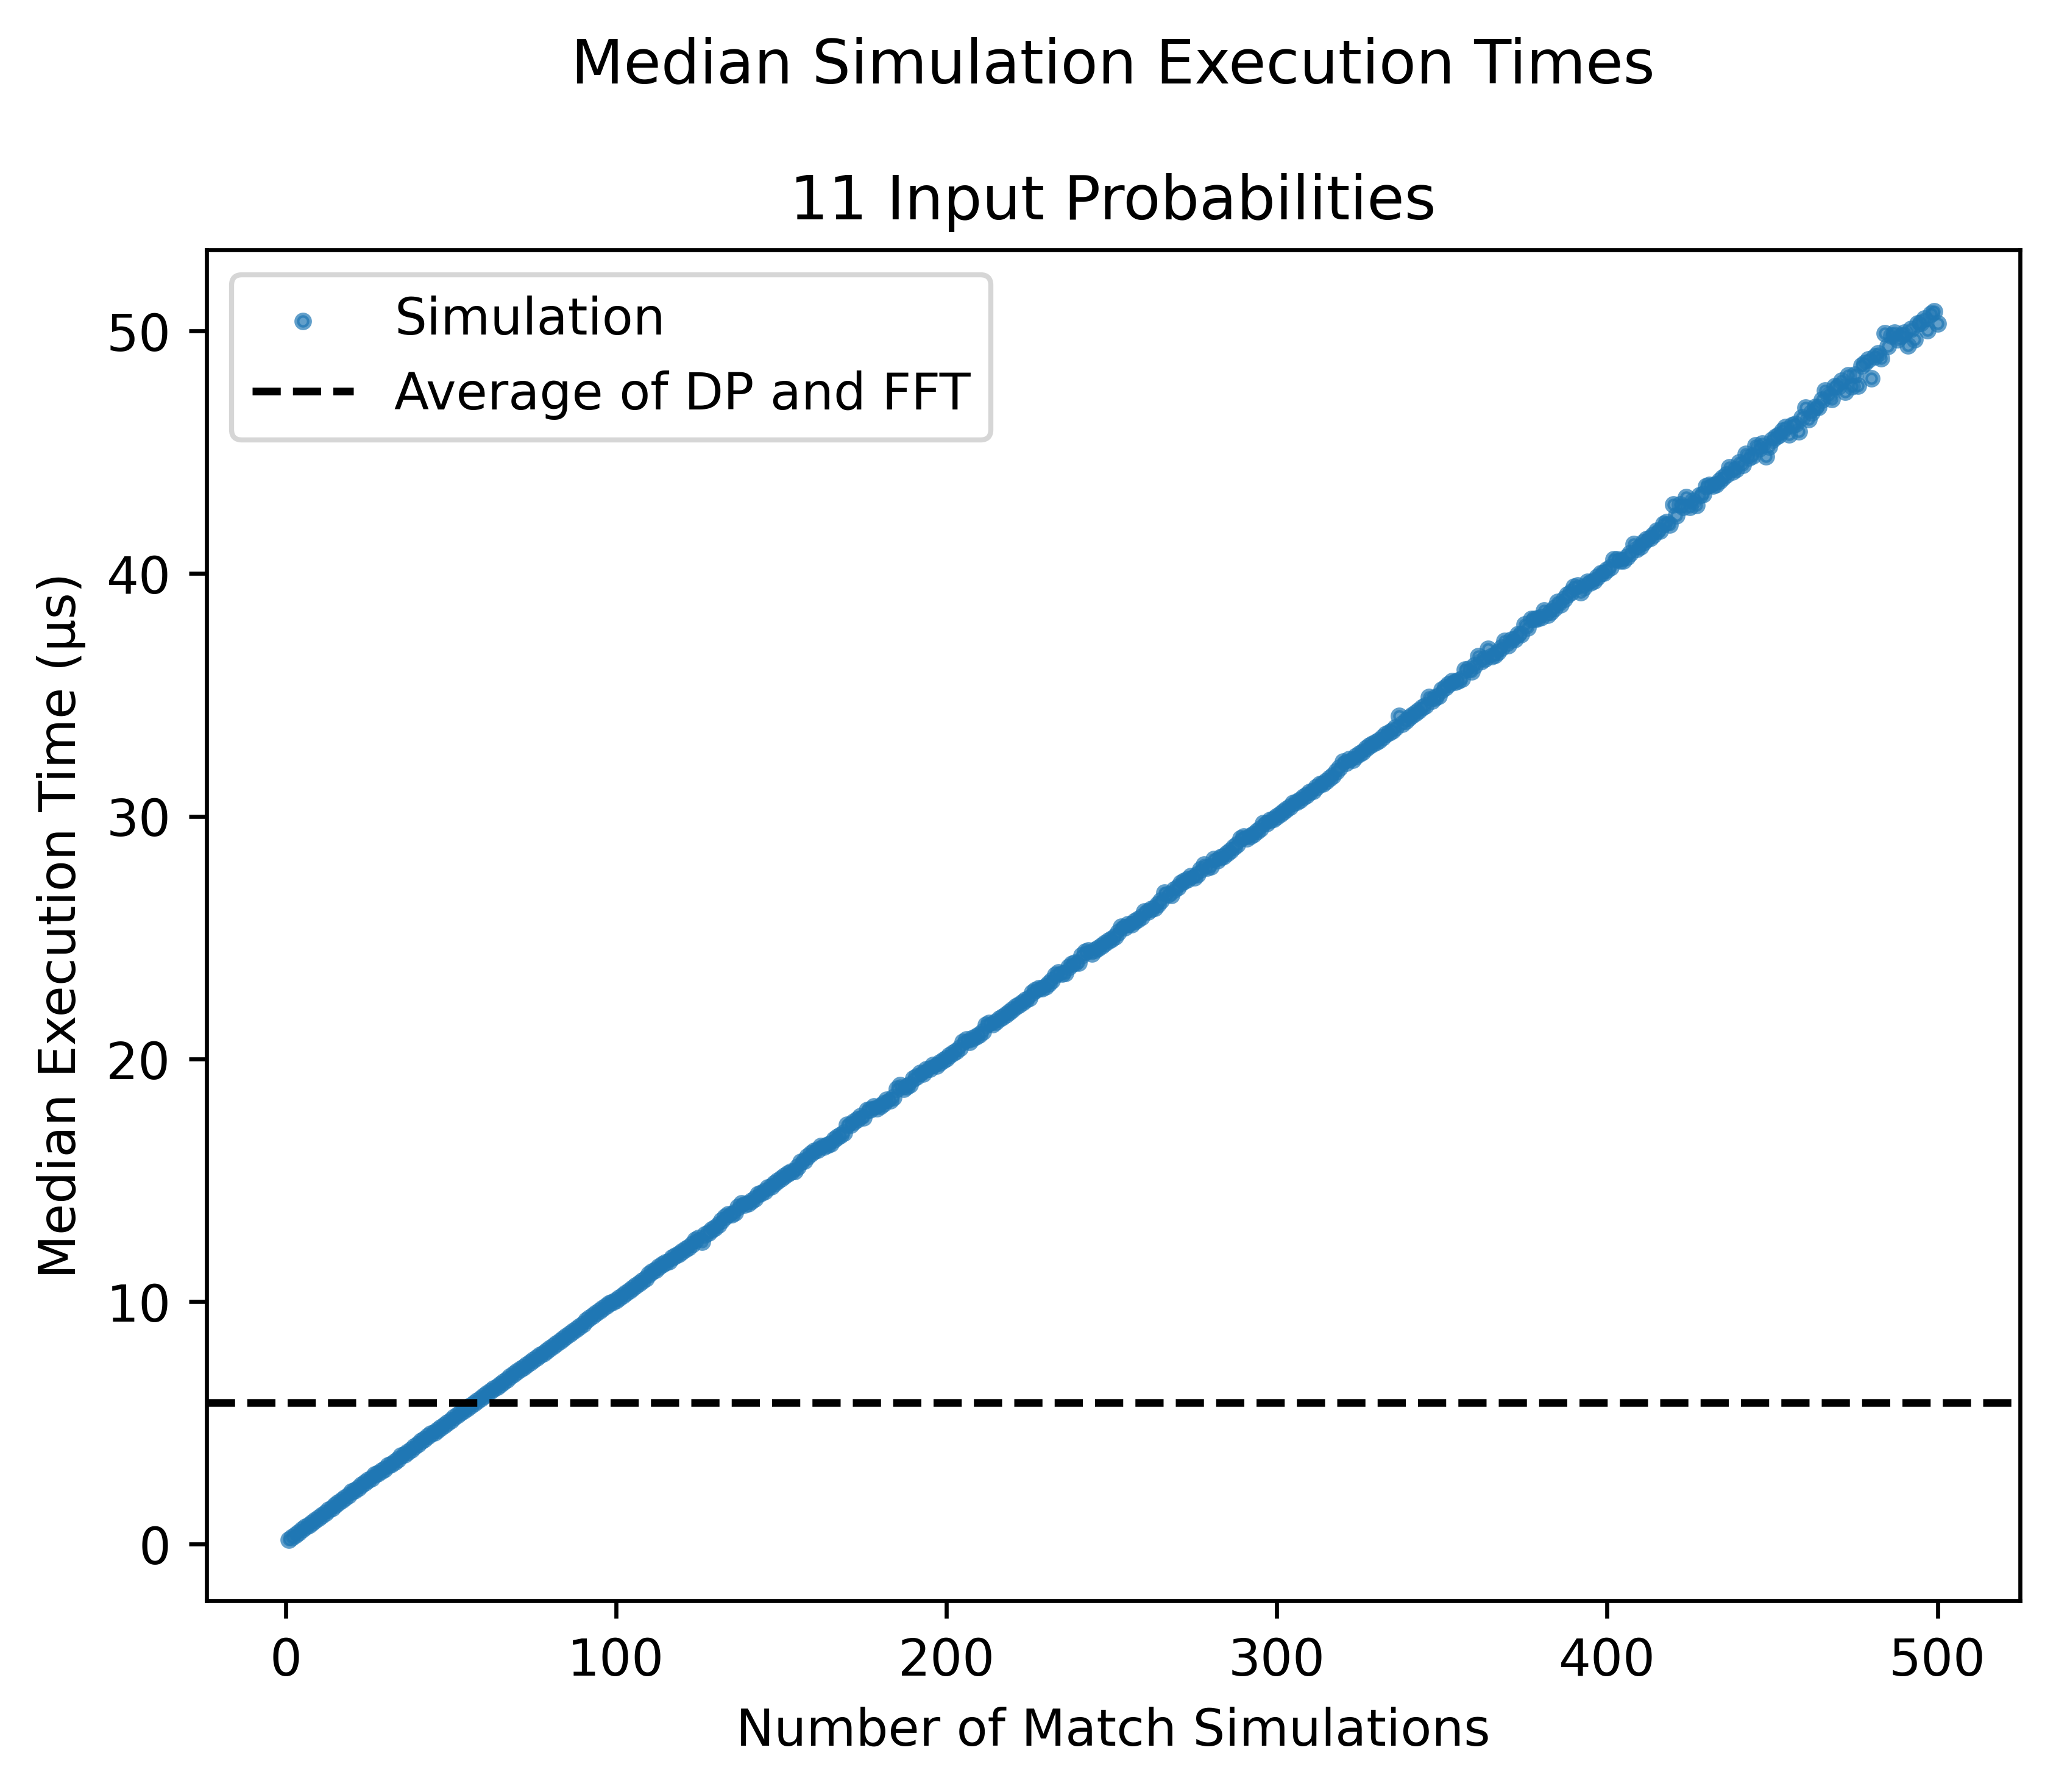

In [18]:
plt.scatter(match_simulations, median_sim_exec_times, s=6, alpha=0.7, label='Simulation')
plt.title('Median Simulation Execution Times\n11 Input Probabilities')
plt.xlabel('Number of Match Simulations')
plt.ylabel('Median Execution Time (µs)')
plt.axhline(exec_time_det_algs_microseconds, linestyle='--', c='black', label='Average of DP and FFT')
plt.legend()
plt.show()

In [19]:
one_sim = median_sim_exec_times[0]
last_sim_amnt = median_sim_exec_times[-1]
print(f'Median Execution Time 1 match simulation: {one_sim}µs')
print(f'Median Execution Time {SIM_MAX} match simulation: {last_sim_amnt}µs')

Median Execution Time 1 match simulation: 0.19955µs
Median Execution Time 500 match simulation: 50.30945µs


In [20]:
# Calculate the interception point
slope = (last_sim_amnt-one_sim)/(SIM_MAX-1)
slope_intercept = last_sim_amnt - slope*SIM_MAX
intersection_point = (exec_time_det_algs_microseconds-slope_intercept)/slope
print(f'Point at which Simulation becomes slower: {intersection_point} Match Simulations')

Point at which Simulation becomes slower: 57.07661859233406 Match Simulations


### Analysis on Convergence Speed
The convergence to the true distribution depending on the number of match simulations is a crucial property of the Simulation Algorithm. We will assess the Simulation algorithm on the convergence to the reference distribution using two distance metrics for probability distributions. 
For reasons of comparability the maximum number of match simulations is set to 10000.

In [21]:
# Redefine the simulation algorithm with fixed seed
def simulation(p_is, n):
    amnts = [0]*(len(p_is)+1)
    for i in range(n):
        goal_amnt = 0
        for j, p_i in enumerate(p_is):
            random.seed(SEED+(i+1)*(j+1))
            u = random.random()
            if u < p_i:
                goal_amnt +=1
        amnts[goal_amnt] += 1
    return [amnt/n for amnt in amnts]

In [22]:
# Run the match simulations and get the distance metrics
SIMULATIONS = 1000
match_simulations = []
cosine_differences = []
max_abs_differences = []
for s in tqdm(range(1, SIMULATIONS+1)):
    simulated_dist = simulation(p_is, s)
    max_abs_differences.append(max([abs(simulated_entry - ref_entry) for simulated_entry, ref_entry in zip(simulated_dist, reference_dist)]))
    cosine_differences.append(scipy.spatial.distance.cosine(reference_dist, simulated_dist))
    match_simulations.append(s)

100%|██████████| 1000/1000 [00:27<00:00, 36.27it/s]


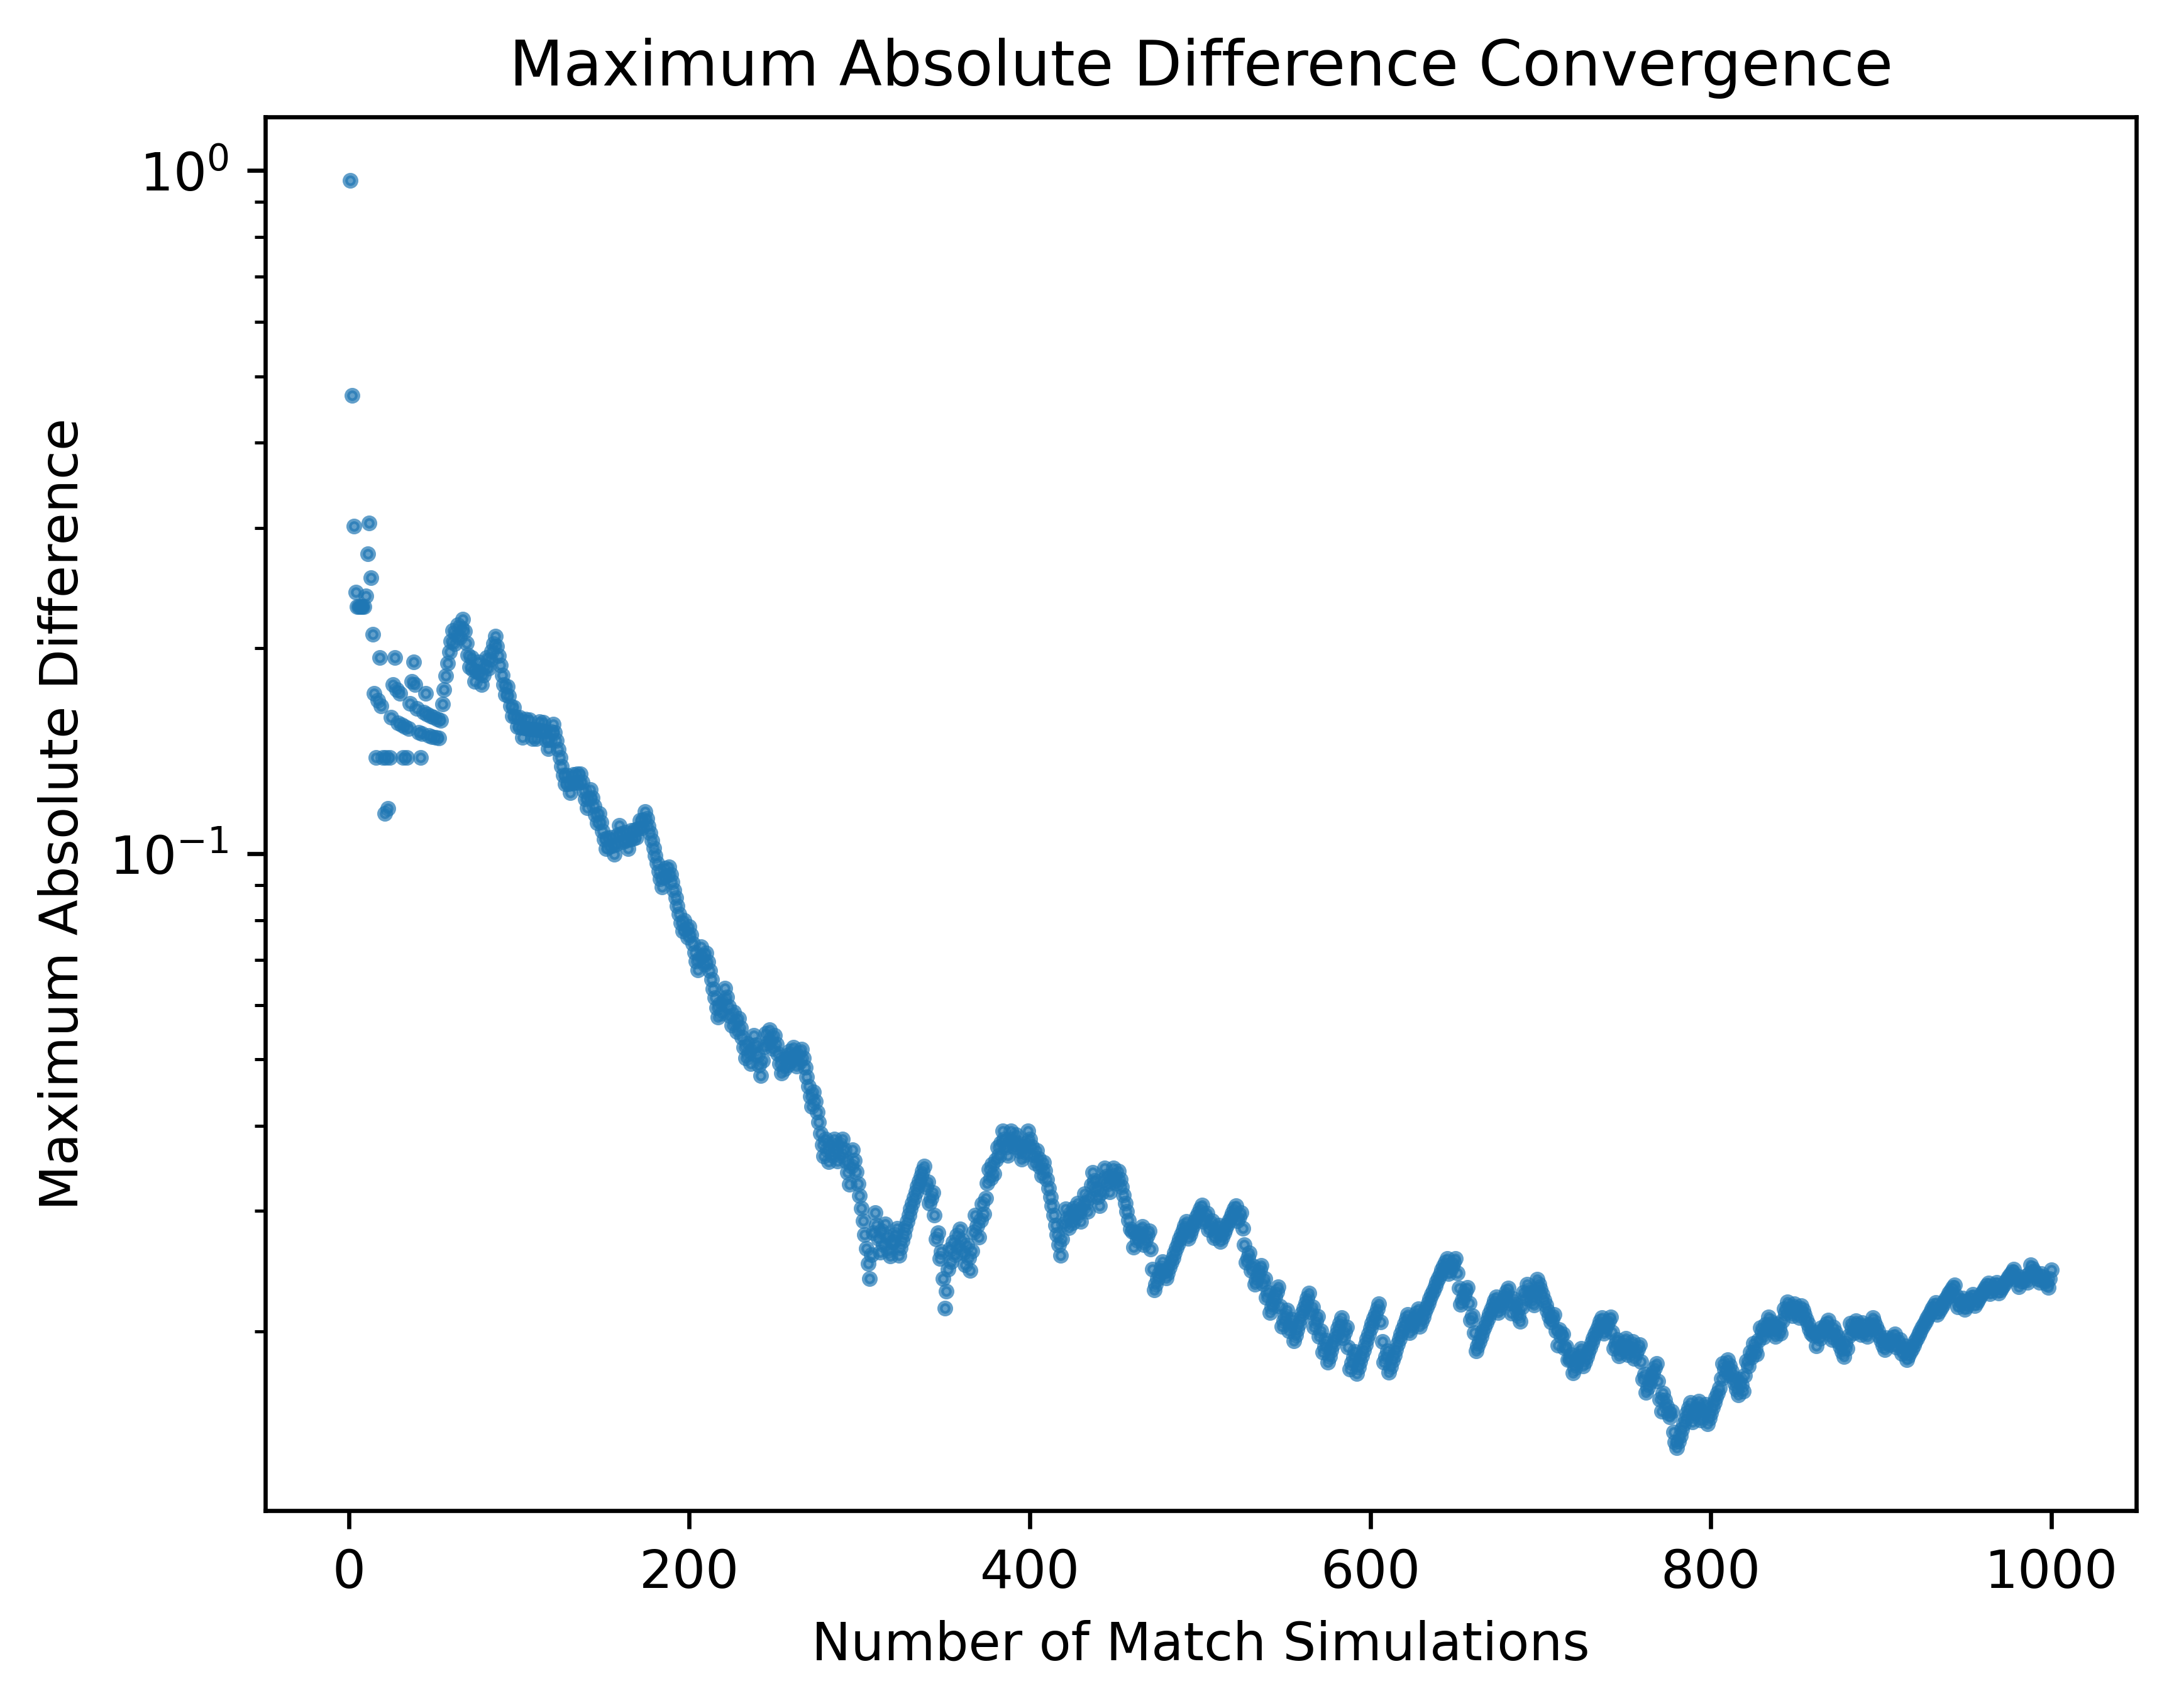

In [23]:
# Plot the maximum absolute difference of the distribution vector entries
plt.clf()
plt.scatter(match_simulations, max_abs_differences, alpha=0.7, s=4)
plt.yscale('log')
plt.title('Maximum Absolute Difference Convergence\n11 Input Probabilities')
plt.xlabel('Number of Match Simulations')
plt.ylabel('Maximum Absolute Difference')
plt.show()

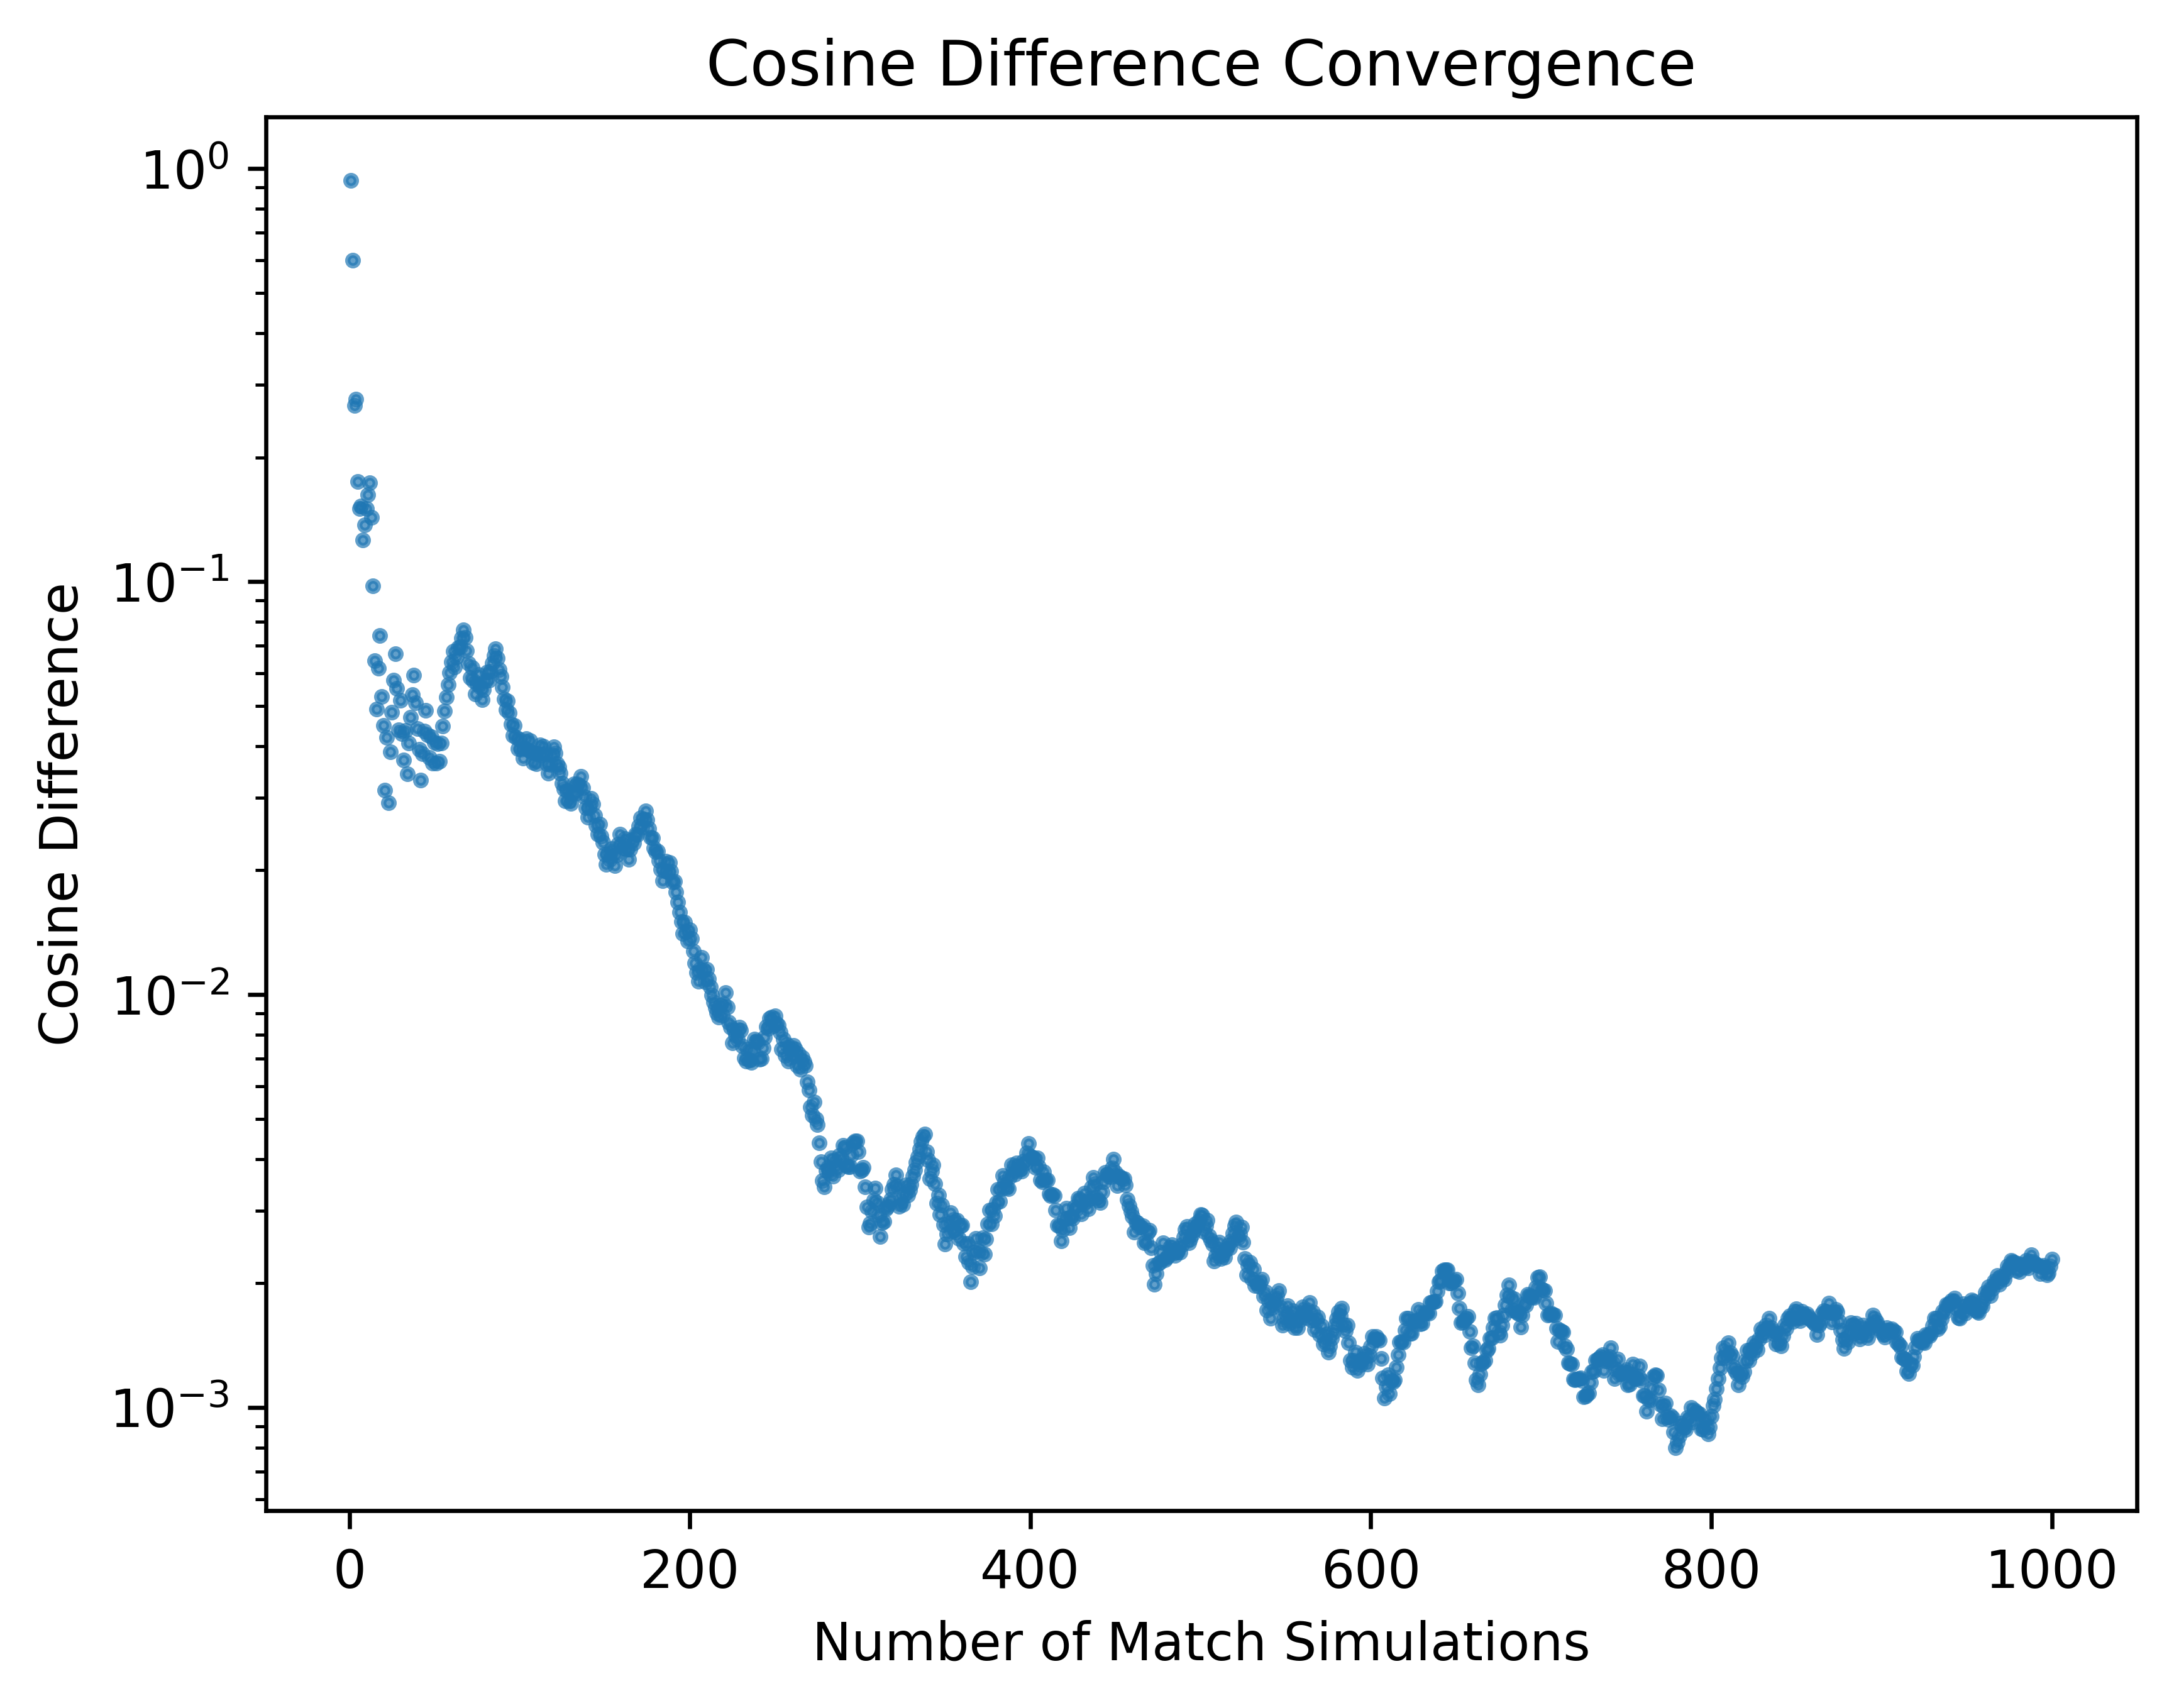

In [24]:
# Plot the cosine similarities of the distribution vectors
plt.clf()
plt.scatter(match_simulations, cosine_differences, alpha=0.7, s=4)
plt.yscale('log')
plt.title('Cosine Difference Convergence\n11 Input Probabilities')
plt.xlabel('Number of Match Simulations')
plt.ylabel('Cosine Difference')
plt.show()